# LH2 Carrier BOG Prediction Digital Twin
**Author:** Perry Giles  
**Date:** November 2025

## Overview
This notebook simulates the thermodynamic behavior of a Liquid Hydrogen (LH2) storage tank during a marine voyage from **Australia to Japan**.

### Key Features
* **Geospatial Input:** Uses real historical wave height and temperature data generated by our Julia module (`LH2_Voyage_Geospatial.xlsx`).
* **Physics Engine:** Uses `CoolProp` (Helmholtz Energy EOS) for high-accuracy cryogenic properties.
* **Sloshing Model:** Dynamic heat leak amplification based on Wave Height ($H_s$), Ship Speed, and Fill Ratio.
* **Continuous Venting:** Simulates a pressure control valve maintaining the tank at a set operating pressure (e.g., 1.3 bar).

> **Prerequisite:** Ensure `LH2_Voyage_Geospatial.xlsx` exists in this folder (run the Julia script first).

In [63]:
# Install CoolProp if you haven't already
# !pip install CoolProp pandas matplotlib openpyxl

import logging
import math
from dataclasses import dataclass
from typing import Optional, List
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

# Configuration
FLUID_NAME = "ParaHydrogen"
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

print(f"Libraries loaded. Using CoolProp version: {CP.get_global_param_string('version')}")

Libraries loaded. Using CoolProp version: 7.2.0


In [64]:
@dataclass
class TankSpecs:
    """
    Physical parameters of the Cargo Containment System (CCS).
    """
    volume_m3: float = 1250.0          
    surface_area_m2: float = 560.0     
    insulation_u_value: float = 0.009  # W/m^2*K
    
    # Operating Pressure Control
    pressure_setpoint_pa: float = 1.3e5  # 1.3 bar absolute (Valve Open Pressure)
    mawp_pa: float = 5.0e5               # Max Allowable Working Pressure

@dataclass
class SimulationConfig:
    """
    Simulation constraints.
    """
    initial_fill_ratio: float = 0.98     # 98% full at departure
    initial_pressure_pa: float = 1.10e5  # 1.1 bar (subcooled start)
    time_step_hours: float = 1.0            
    design_speed_knots: float = 15.0

print("Configuration classes defined.")

Configuration classes defined.


In [65]:
class VoyageProfile:
    """
    Wrapper for the geospatial voyage time series.
    Reads the Excel file generated by the Julia script.
    """
    REQUIRED_COLUMNS = ("Time_hr", "Ambient_Temp_K", "Sig_Wave_Height_m")

    def __init__(self, df: pd.DataFrame):
        self.data = df

    @classmethod
    def from_excel(cls, path: str) -> "VoyageProfile":
        if not os.path.exists(path):
            raise FileNotFoundError(f"CRITICAL: '{path}' not found. Run the Julia geospatial script first.")
            
        df = pd.read_excel(path)
        
        # Validation
        missing = [c for c in cls.REQUIRED_COLUMNS if c not in df.columns]
        if missing:
            raise ValueError(f"Voyage profile missing columns: {missing}")
            
        print(f"Voyage Profile loaded: {len(df)} time steps ({len(df)/24:.1f} days).")
        return cls(df)

In [66]:
class BOGSimulator:
    def __init__(self, tank: TankSpecs, voyage: VoyageProfile, config: SimulationConfig):
        self.tank = tank
        self.voyage = voyage.data
        self.config = config
        self.results = []

    def _get_sloshing_factor(self, wave_height_m, speed, fill_ratio):
        """
        Calculates heat leak amplification due to sloshing.
        Factors:
        1. Wave Height (External Excitation)
        2. Ship Speed (Frequency Excitation)
        3. Fill Ratio (Resonance - high sloshing at partial fill)
        """
        # 1. Wave Factor: Non-linear scaling
        Hs = max(0.0, wave_height_m)
        wave_factor = 1.0 + 0.15 * (Hs**1.3)
        
        # 2. Speed Factor
        speed_factor = (speed / 15.0) ** 0.5
        
        # 3. Resonance (Double Gaussian peak at 30% and 70% fill)
        f = fill_ratio
        resonance = 0.2 * (np.exp(-((f-0.3)/0.1)**2) + np.exp(-((f-0.7)/0.1)**2))
        
        return max(1.0, (wave_factor * speed_factor) + resonance)

    def run(self):
        print("Starting Simulation...")
        
        # --- Initialization ---
        P_current = self.config.initial_pressure_pa
        # Get Density of liquid at start
        rho_liq = CP.PropsSI("D", "P", P_current, "Q", 0.0, FLUID_NAME)
        mass_current = self.tank.volume_m3 * self.config.initial_fill_ratio * rho_liq
        
        # Get Internal Energy
        u_current = CP.PropsSI("U", "P", P_current, "Q", 0.0, FLUID_NAME)
        U_total = u_current * mass_current 
        
        initial_mass = mass_current
        cumulative_bog = 0.0
        dt_s = self.config.time_step_hours * 3600.0

        records = []

        # --- Time Loop ---
        for row in self.voyage.itertuples():
            t_amb = row.Ambient_Temp_K
            wave_h = row.Sig_Wave_Height_m
            speed = getattr(row, "Ship_Speed", self.config.design_speed_knots)
            lat = getattr(row, "Latitude", 0.0)

            # 1. Current Bulk State
            rho_current = mass_current / self.tank.volume_m3
            u_specific = U_total / mass_current
            
            try:
                # Flash Calculation (Density + Internal Energy -> Temp, Pressure)
                T_fluid = CP.PropsSI("T", "D", rho_current, "U", u_specific, FLUID_NAME)
                P_fluid = CP.PropsSI("P", "D", rho_current, "U", u_specific, FLUID_NAME)
            except:
                # EOS Fallback
                P_fluid = P_current
                T_fluid = CP.PropsSI("T", "P", P_fluid, "Q", 0.0, FLUID_NAME)

            # 2. Heat Transfer
            # Static Leak
            q_static = self.tank.insulation_u_value * self.tank.surface_area_m2 * (t_amb - T_fluid)
            
            # Sloshing Multiplier
            ssf = self._get_sloshing_factor(wave_h, speed, mass_current/initial_mass)
            q_total = q_static * ssf

            # 3. Energy Balance & Venting
            U_trial = U_total + (q_total * dt_s)
            
            # Check Trial Pressure
            u_trial_spec = U_trial / mass_current
            try:
                P_trial = CP.PropsSI("P", "D", rho_current, "U", u_trial_spec, FLUID_NAME)
            except:
                P_trial = P_current # Fallback
            
            bog_kg = 0.0
            mode = "Closed"

            # --- Venting Logic (Isobaric Control) ---
            if P_trial >= self.tank.pressure_setpoint_pa:
                mode = "Venting"
                
                # Enthalpy of Vaporization (h_fg)
                h_gas = CP.PropsSI("H", "P", self.tank.pressure_setpoint_pa, "Q", 1.0, FLUID_NAME)
                h_liq = CP.PropsSI("H", "P", self.tank.pressure_setpoint_pa, "Q", 0.0, FLUID_NAME)
                h_fg = h_gas - h_liq
                
                # Mass boil-off to neutralize heat input
                # m_dot = Q / h_fg
                if h_fg > 0:
                    bog_kg = (q_total / h_fg) * dt_s
                
                # Update State
                mass_current -= bog_kg
                U_total = U_trial - (bog_kg * h_gas)
                P_current = self.tank.pressure_setpoint_pa # Clamped
            else:
                U_total = U_trial
                P_current = P_trial

            cumulative_bog += bog_kg

            records.append({
                "Time_hr": row.Time_hr,
                "Lat": lat,
                "Wave_Height_m": wave_h,
                "Pressure_bar": P_current/1e5,
                "Temperature_K": T_fluid,
                "Heat_Leak_W": q_total,
                "SSF": ssf,
                "BOG_kg_step": bog_kg,
                "Cum_BOG_kg": cumulative_bog,
                "BOR_pct": (cumulative_bog/initial_mass)*100
            })

        self.results = pd.DataFrame(records)
        print(f"Simulation Complete. Final BOR: {self.results['BOR_pct'].iloc[-1]:.3f}%")
        return self.results

In [67]:
# 1. Load Data
INPUT_FILE = "LH2_Voyage_Geospatial.xlsx"
voyage = VoyageProfile.from_excel(INPUT_FILE)

# 2. Define Specs
tank = TankSpecs(
    volume_m3=1250.0,
    pressure_setpoint_pa=1.3e5  # Vent at 1.3 bar
)

config = SimulationConfig(
    initial_fill_ratio=0.98,
    initial_pressure_pa=1.10e5 # Start at 1.1 bar
)

# 3. Run
sim = BOGSimulator(tank, voyage, config)
results_df = sim.run()

# 4. Save
results_df.to_excel("LH2_Digital_Twin_Results.xlsx", index=False)
results_df.head()

Voyage Profile loaded: 305 time steps (12.7 days).
Starting Simulation...
Simulation Complete. Final BOR: 3.937%


,Time_hr,Lat,Wave_Height_m,Pressure_bar,Temperature_K,Heat_Leak_W,SSF,BOG_kg_step,Cum_BOG_kg,BOR_pct
0,0,-38.300000,1.30,1.097246,20.535314,1784.242800,1.262260,0.0,0.0,0.0
1,1,-38.418789,1.38,1.099710,20.543044,1787.943647,1.264971,0.0,0.0,0.0
2,2,-38.537578,1.22,1.102142,20.550788,1762.545656,1.247093,0.0,0.0,0.0
3,3,-38.656367,0.50,1.104257,20.558418,1530.993105,1.083337,0.0,0.0,0.0
4,4,-38.775156,0.58,1.106412,20.565044,1558.137567,1.102622,0.0,0.0,0.0


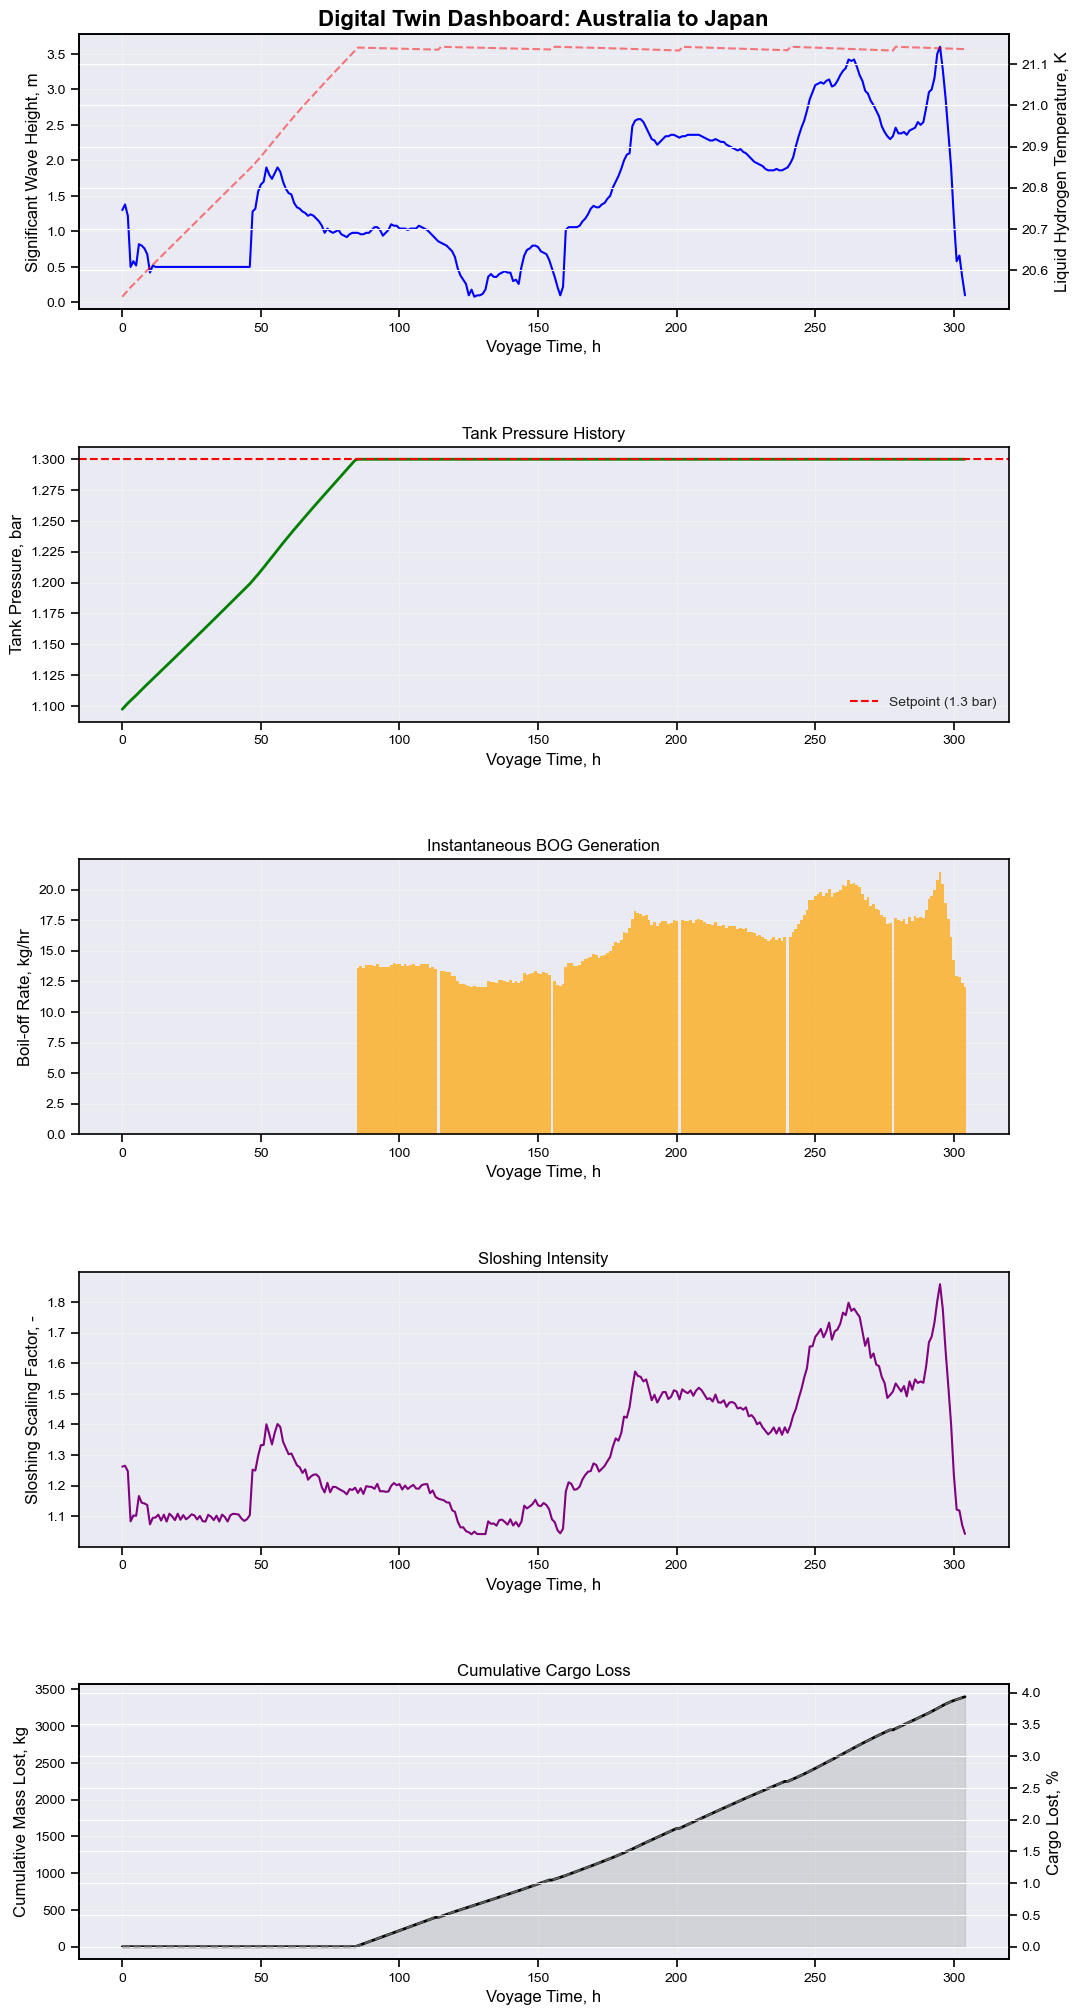

In [68]:
# Increase vertical size to 25 to give space for the extra axes numbers
fig, axes = plt.subplots(5, 1, figsize=(12, 25), sharex=True)

# --- Plot 1: Environmental Conditions ---
ax1 = axes[0]
ax1.plot(results_df['Time_hr'], results_df['Wave_Height_m'], color='blue', label='Sig. Wave Height')
ax1.set_ylabel('Significant Wave Height, m', color='black', fontsize=12)
ax1.set_title('Digital Twin Dashboard: Australia to Japan', fontsize=16, weight='bold', color='black')
ax1.grid(True, alpha=0.3)

# Add Temp on secondary axis (Right)
ax1_twin = ax1.twinx()
ax1_twin.plot(results_df['Time_hr'], results_df['Temperature_K'], color='red', linestyle='--', alpha=0.5, label='LH2 Temp')
ax1_twin.set_ylabel('Liquid Hydrogen Temperature, K', color='black', fontsize=12)

# --- Plot 2: Tank Pressure ---
ax2 = axes[1]
ax2.plot(results_df['Time_hr'], results_df['Pressure_bar'], color='green', linewidth=2)
ax2.axhline(y=tank.pressure_setpoint_pa/1e5, color='red', linestyle='--', label='Setpoint (1.3 bar)')
ax2.set_ylabel('Tank Pressure, bar', color='black', fontsize=12)
ax2.legend(loc='lower right')
ax2.set_title('Tank Pressure History', color='black', fontsize=12)
ax2.grid(True, alpha=0.3)

# --- Plot 3: Instantaneous BOG Rate ---
ax3 = axes[2]
ax3.bar(results_df['Time_hr'], results_df['BOG_kg_step'], width=1.0, color='orange', alpha=0.7)
ax3.set_ylabel('Boil-off Rate, kg/hr', color='black', fontsize=12)
ax3.set_title('Instantaneous BOG Generation', color='black', fontsize=12)
ax3.grid(True, alpha=0.3)

# --- Plot 4: Sloshing Factor ---
ax4 = axes[3]
ax4.plot(results_df['Time_hr'], results_df['SSF'], color='purple', label='Sloshing Scaling Factor')
ax4.set_ylabel('Sloshing Scaling Factor, -', color='black', fontsize=12)
ax4.set_title('Sloshing Intensity', color='black', fontsize=12)
ax4.grid(True, alpha=0.3)

# --- Plot 5: Cumulative Boil-off ---
ax5 = axes[4]
# Left Axis: Mass in kg
ax5.plot(results_df['Time_hr'], results_df['Cum_BOG_kg'], color='black', linewidth=2, label='Total Mass Lost')
ax5.fill_between(results_df['Time_hr'], results_df['Cum_BOG_kg'], color='black', alpha=0.1) 
ax5.set_ylabel('Cumulative Mass Lost, kg', color='black', fontsize=12)
ax5.set_title('Cumulative Cargo Loss', color='black', fontsize=12)
ax5.grid(True, alpha=0.3)

# Right Axis: Percentage of Cargo (BOR %)
ax5_twin = ax5.twinx()
ax5_twin.plot(results_df['Time_hr'], results_df['BOR_pct'], color='gray', linestyle='--', alpha=0.7, label='Loss %')
ax5_twin.set_ylabel('Cargo Lost, %', color='black', fontsize=12)

# --- STYLING: FORCE BLACK AXIS SPINES AND TICKS ---
all_axes = list(axes) + [ax1_twin, ax5_twin] # Include secondary axes

for ax in all_axes:
    # 1. Force Ticks to be Black, Outward, and visible size
    ax.tick_params(axis='both', which='both', colors='black', labelcolor='black', 
                   direction='out', length=6, width=1.2)
    
    # 2. Force the "Spines" (the box borders) to be Black and slightly thicker
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

# --- FORCE X-AXIS LABELS & TICKS ON ALL CHARTS ---
for ax in axes:
    ax.set_xlabel('Voyage Time, h', fontsize=12, color='black')
    ax.tick_params(labelbottom=True) # Ensure numbers are visible on x-axis for all

# Adjust layout
plt.subplots_adjust(hspace=0.5) 
plt.show()